In [171]:
import autograd.numpy as np 
import matplotlib.pyplot as plt
from fgbuster import CMB, Dust, Synchrotron, MixingMatrix
from fgbuster.observation_helpers import standardize_instrument, get_observation
from fgbuster.cosmology import _get_Cl_cmb, _get_Cl_noise
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import healpy as hp
import numdifftools.core as nd
import math as m
from fgbuster.algebra import  W_dBdB, W_dB, W, _mmm, _utmv, _mmv, comp_sep
import pylab as pl
import numdifftools
import numpy as np
from iminuit import Minuit
from iminuit.cost import UnbinnedNLL 
from scipy.stats import norm
import scipy as sp


In [172]:
nside = 64
model = 'd0s0'

In [173]:
instr = np.load('/Users/alicepirotta/Desktop/APC/MCMC/instrument_LB_IMOv1.npy', allow_pickle=True).item()
instr_ = {}
instr_['frequency'] = np.array([instr[f]['freq'] for f in instr.keys()])
instr_['depth_p'] = np.array([instr[f]['P_sens'] for f in instr.keys()])
instr_['fwhm'] = np.array([instr[f]['beam'] for f in instr.keys()])
instr_['depth_i'] = instr_['depth_p']/np.sqrt(2)
instrument = standardize_instrument(instr_)

In [174]:
d_fgs_N = get_observation(instrument, model, noise=True, nside=nside)
d_fgs = get_observation(instrument, model, noise=False, nside=nside)

#take only the Q and U, not I
freq_maps_N= d_fgs_N[:,1:,:]
freq_maps= d_fgs[:,1:,:]

n_freqs = freq_maps.shape[0]
n_stokes = freq_maps.shape[1]
n_pix = freq_maps.shape[2]


In [175]:
components= [CMB(), Dust(150.), Synchrotron(150.)]

In [176]:
M = MixingMatrix(*components) 
M_ev = M.evaluator(instrument.frequency)
M_dB_ev = M.diff_evaluator(instrument.frequency)
M_dB_dB_ev= M.diff_diff_evaluator(instrument.frequency)

In [177]:
# N = np.diag((instrument.depth_p / hp.nside2resol(nside, arcmin=True))**2)
# invN = np.linalg.inv(N)

invN = np.linalg.inv(np.diag((instrument.depth_p / hp.nside2resol(nside, arcmin=True))**2))
N = np.zeros ((22,22))



In [178]:
# np.random.seed(10)
gains_true = np.ones(21)
x_true = np.concatenate((M.defaults, gains_true))
x_init = np.random.uniform(low=x_true * (1 - 1 / 50000), high= x_true * (1 + 1 / 50000))
n_sp = len(x_init[:-n_freqs+1])
n_channels= 22

In [179]:
# dati = np.einsum('abc,cbx-> ax',freq_maps,freq_maps.T)


# def aver_likelihood(y):
#     Bd, T, Bs, a, b, c, d, e, f, g, i, l, m, n, o, p, q, r, s, t, u, v, w, z = y
#     h = 1
#     G = np.diag([a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, r, s, t, u, v, w, z ])
#     A =G.dot(M_ev(np.array([Bd,T,Bs]))) 
#     logL=0
#     NA= np.einsum('ab,bc->ac', invN,A)
#     AtNA = np.linalg.inv(np.einsum('ab,bc,cd->ad',A.T,invN,A))
#     AtN= np.einsum('ab,bc->ac', A.T, invN)
#     P = np.einsum ('ab,bc,cd->ad',NA,AtNA,AtN)
#     dN = dati+N
#     logL = logL - np.trace(np.einsum('ab,bc->ac',P,dN))/2
#     if logL != logL:
#         return 0.0
#     return logL

In [180]:
dati = np.einsum('abc,cbx-> ax',freq_maps,freq_maps.T)


def aver_likelihood(y):
    Bd, T, Bs, a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, r, s, t, u, v, z = y
    w = n_channels - (a+b+c+d+e+f+g+h+i+l+m+n+o+p+q+r+s+t+u+v+z)
    G = np.diag([a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, r, s, t, u, v, w, z ])
    A =G.dot(M_ev(np.array([Bd,T,Bs]))) 
    logL=0
    NA= np.einsum('ab,bc->ac', invN,A)
    AtNA = np.linalg.inv(np.einsum('ab,bc,cd->ad',A.T,invN,A))
    AtN= np.einsum('ab,bc->ac', A.T, invN)
    P = np.einsum ('ab,bc,cd->ad',NA,AtNA,AtN)
    dN = dati+N
    logL = logL - np.trace(np.einsum('ab,bc->ac',P,dN))/2
    if logL != logL:
        return 0.0
    return logL

In [181]:
# def spec_likelihood(y):
#     Bd, T, Bs, a, b, c, d, e, f, g, i, l, m, n, o, p, q, r, s, t, u, v, w, z = y
#     h = n_channels - (a+b+c+d+e+f+g+i+l+m+n+o+p+q+r+s+t+u+v+w+z)
#     G = np.diag([a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, r, s, t, u, v, w, z])
#     A =G.dot(M_ev(np.array([Bd,T,Bs]))) 
#     logL = 0
#     AinvNd= np.einsum('ba,ac,cde->bde', A.T, invN, freq_maps)
#     AtinvNA = np.linalg.inv(np.einsum('ab,bc,ce->ae',A.T,invN,A))
#     logL = logL + np.einsum('abc,cd,dba->', AinvNd.T, AtinvNA, AinvNd)
#     if logL != logL:
#         return 0.0
#     return logL

In [182]:
c = UnbinnedNLL(x_init, aver_likelihood)

m = Minuit(aver_likelihood,x_init)
#m.limits = [(1.539, 1.541), (19.9, 20.1), (-3.001,-2.999), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.9,1.1), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001)]
#m.limits = [(1.4, 1.6), (19, 21), (-3.5,-2.5), (0,2), (0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2)]
m.precision =1e-18
m.migrad() # find minimum
m.hesse()   # compute uncertainties

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.715e+10                 │             Nfcn = 2884              │
│ EDM = 0.000235 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  1.53994  │  0.00032  │            │            │         │         │       │
│ 1 │ x1   │  20.003   │   0.012   │            │            │         │         │       │
│ 2 │ x2   │  -3.0000  │  0.0018   │            │            │         │         │       │
│ 3 │ x3   │1000.00e-3 │  0.12e-3  │            │            │         │         │       │
│ 4 │ x4   │  1.00000  │  0.00012  │            │            │         │         │       │
│ 5 │ x5   │  1.00001  │  0.00012  │            │            │         │         │       │
│ 6 │ x6   │ 999.99e-3 │  0.12e-3  │            │            │         │         │       │
│ 7 │ x7   │ 999.98e-3 │  0.12e-3  │            │            │         │         │       │
│ 8 │ x8   │  1.00000  │  0.00012  │            │            │         │         │       │
│ 9 │ x9   │ 999.99e-3 │  0.12e-3  │            │            │         │         │       │
│ 10│ x10  │  1.00000  │  0.00011  │            │            │         │         │       │
│ 11│ x11  │ 999.98e-3 │  0.12e-3  │            │            │         │         │       │
│ 12│ x12  │  1.00000  │  0.00011  │            │            │         │         │       │
│ 13│ x13  │  1.00000  │  0.00009  │            │            │         │         │       │
│ 14│ x14  │  1.00000  │  0.00008  │            │            │         │         │       │
│ 15│ x15  │  1.0000   │  0.0001   │            │            │         │         │       │
│ 16│ x16  │  1.00000  │  0.00008  │            │            │         │         │       │
│ 17│ x17  │  1.00000  │  0.00007  │            │            │         │         │       │
│ 18│ x18  │  1.00000  │  0.00005  │            │            │         │         │       │
│ 19│ x19  │  1.00001  │  0.00005  │            │            │         │         │       │
│ 20│ x20  │  1.00001  │  0.00006  │            │            │         │         │       │
│ 21│ x21  │  1.00001  │  0.00005  │            │            │         │         │       │
│ 22│ x22  │  1.00001  │  0.00004  │            │            │         │         │       │
│ 23│ x23  │1000.00e-3 │  0.06e-3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│     │        x0        x1        x2        x3        x4        x5        x6        x7        x8        x9       x10       x11       x12       x13       x14       x15       x16       x17       x18       x19       x20       x21       x22       x23 │
├─────┼─────────────────────────────────

In [183]:
print(m.values[0:])

[1.5399356054675317, 20.00321749810289, -2.999984124144416, 0.9999996315121207, 1.0000041522633558, 1.0000060324033293, 0.9999873479751811, 0.9999817765619173, 1.0000047968636159, 0.9999909082111159, 1.0000019551419328, 0.9999831749042196, 1.0000019979163886, 1.000000652626071, 1.0000022865364357, 1.0000001924737834, 1.0000006764385172, 1.0000022845841345, 1.0000047656583613, 1.0000059263073224, 1.000005880026254, 1.000006681685642, 1.0000063460331217, 0.9999985902695333]


In [184]:
print(repr(m.covariance))

[[ 9.93992194e-08 -3.16156579e-06 -6.79064381e-08 -1.38242033e-10
  -6.90666430e-11 -2.28288556e-10 -3.97485795e-10 -2.91023912e-10
  -7.13585026e-10 -5.47558464e-10 -1.05639355e-09 -3.57228987e-10
  -1.14005890e-09 -2.31577823e-10  1.72028442e-09 -1.48075726e-09
  -2.46140016e-10  1.88840352e-09  3.50141271e-09  3.21352099e-09
   2.88221905e-09  1.41048521e-09 -9.61280699e-10 -3.51141112e-09]
 [-3.16156579e-06  1.52142003e-04 -5.22597662e-07 -1.42365905e-08
  -1.02518632e-08 -7.45296756e-09 -9.25001972e-09 -1.03215300e-08
  -1.10875501e-08 -1.12142897e-08 -1.77779081e-08 -1.34866122e-08
  -2.74044542e-08 -4.35610174e-08 -2.67991303e-08 -3.27159716e-08
  -5.37291676e-08 -2.84211061e-08  2.73409140e-08  8.70540685e-08
   7.73063445e-08  1.33976796e-07  1.32242600e-07 -1.79717410e-07]
 [-6.79064381e-08 -5.22597662e-07  3.10935668e-06  3.03568797e-08
  -1.09379749e-09 -9.06379059e-09 -8.24004737e-09 -3.23887420e-09
  -8.30000847e-09 -5.56362808e-09 -6.13926579e-09 -1.18829287e-09
  -1.507

In [185]:
# #bnds = ((1.539, 1.541), (19.9, 20.1), (-3.001,-2.999), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.9,1.1), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001))
# bnds = ((1.5, 1.6), (18, 22), (-4,-2), (0,2), (0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2))
# result= minimize(aver_likelihood, x_init, method='TNC', tol = 1e-18, bounds=bnds)

# print(result.x)
# m.values = result.x


In [186]:
# H = nd.Hessian(aver_likelihood)
# h = H(x_init) 

# sigma_params_square = np.linalg.inv(h)
# sigma_params_square_inv= h

# m.covariance = sigma_params_square

In [187]:
def _G(gain_val_arr, n_freq,known_band):
    """
    Gain matrix G
    """
    assert len(gain_val_arr) == n_freq-1
    gain_all = list(gain_val_arr)[:known_band]+[n_freq-np.sum(gain_val_arr)]+list(gain_val_arr)[known_band:] 
    
    return np.diag(gain_all)

G= _G(m.values[3:], n_freq=n_freqs, known_band=0)
print(G.shape)
print(G)

(22, 22)
[[1.00000394 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.99999963 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         1.00000415 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         1.00000603 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.99998735 0.
  0.         0.        

In [188]:
def _G_dB(gain_params, n_freq, known_band):
    # this is mainly made of zeros
    G_dB = np.zeros([len(gain_params), n_freq, n_freq])
    for gi, _ in enumerate(gain_params):
        if gi >= known_band:
            fi = gi + 1
        else:
            fi = gi
        G_dB[gi, fi, fi] = 1
        G_dB[gi, known_band, known_band] = -1
    
    return G_dB

G_dB=_G_dB(m.values[3:], n_freq=n_freqs, known_band=0)
print(_G_dB(m.values[3:], n_freq=n_freqs, known_band=0).shape)
print(_G_dB(m.values[3:], n_freq=n_freqs, known_band=0))

(21, 22, 22)
[[[-1.  0.  0. ...  0.  0.  0.]
  [ 0.  1.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  ...
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 [[-1.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  1. ...  0.  0.  0.]
  ...
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 [[-1.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  ...
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 ...

 [[-1.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  ...
  [ 0.  0.  0. ...  1.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 [[-1.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  ...
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  1.  0.]
  [ 0.  0.  0. 

In [189]:
def A_ev(x):
        x_sp = x[:n_sp]
        x_gain = x[n_sp:]
        M_x = M_ev(x_sp)
        G_x = _G(x_gain, n_freqs, known_band=0)
        return np.einsum('fe, ...ec -> ...fc', G_x, M_x)

A_maxL = A_ev(m.values)
print(A_maxL.shape)

(22, 3)


In [190]:
AtN=A_maxL.T.dot(invN)
AtNA=np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))

comp_maps=np.einsum ('cg,gs,sij->cij', AtNA,AtN, freq_maps)

residual_maps_QU = comp_maps[0]
zeros=np.zeros((1, 49152))
residual_maps_IQU = np.vstack((zeros, residual_maps_QU))

In [191]:
# #multipole range 
lmin= 2
lmax= 2*nside-1
ell = np.arange(lmin,lmax+1)


# #power spectrum of the total residual 
# Cl_BB_residual =hp.anafast(residual_maps_IQU)[2,lmin:lmax+1] #with [2] I select the B mode #closed to bias
# Dl_BB_residual = (ell*(ell+1)*Cl_BB_residual)/(2*m.pi)


# #Cl theory 
Cl_BB_r1 = _get_Cl_cmb(Alens=0.0, r=1.)[2][lmin:lmax+1]
Cl_BB_r_001 = _get_Cl_cmb(Alens=0.0, r=0.001)[2] [lmin:lmax+1]

# #Dl theory
# Dl_BB_r001 = (ell*(ell+1)*Cl_BB_r_001)/(2*m.pi)


# #lensing
# Cl_lens = _get_Cl_cmb(Alens=1.0, r=0.)[2][lmin:lmax+1]
# Dl_lens = (ell*(ell+1)*Cl_lens)/(2*m.pi)

# #plot power spectra
# plt.loglog(ell, Dl_BB_residual, label = "Dl_BB_residual")
# plt.loglog(ell, Dl_lens, label = "Dl_lensing")
# plt.loglog(ell, Dl_BB_r001, label = "Dl_BB_r0.001")
# plt.xlabel(r'$\ell$')
# plt.ylabel(r'$\ell$* ($\ell$+1)*C$\ell$/2$\pi$')
# plt.legend()

In [192]:
# Data = Cl_BB_residual + Cl_lens #it is needed by the cosmological likelihood
fsky = 1
# F = np.sum((2*ell+1) * fsky / 2*Cl_BB_r1** 2 / Data ** 2) #it is a scalar because I am using comsological likelihood
# sigma_r_fisher = np.sqrt(1.0 / F)

In [193]:
i_cmb = M.components.index('CMB')
W_maxL = np.einsum ('cg,gs->cs', AtNA,AtN)[i_cmb,:]
print(W_maxL)

[-0.03041567 -0.01610332 -0.0156709  -0.00607419 -0.00238705  0.00445991
  0.00294762  0.02191532  0.00399273  0.0433089   0.09867333  0.12125224
  0.06439243  0.17959819  0.15565576  0.20583482  0.11846406  0.0532542
  0.03602779  0.00161813 -0.02199462 -0.01875053]


In [194]:
def _G_M_dB(G,M_dB):
    return np.einsum('fe, p...ec -> p...cf', G, M_dB)

def _G_dB_M(G_dB, M):
    return np.einsum('pef, ...ec -> p...cf', G_dB, M)

def _G_dB_M_dB (G_dB,M_dB):
    return np.einsum('gef, pec -> gpcf', G_dB, M_dB)

def _M_dB_G_dB (M_dB,G_dB):
    return np.einsum('pec, gef -> pgcf', M_dB, G_dB)

In [195]:
def A_dB_ev(x):
    x_sp = x[:n_sp]
    x_gain = x[n_sp:]

    M_x = M_ev(x_sp)
    G_x = _G(x_gain, n_freqs, known_band=0)
 

    G_dB_x = _G_dB(x_gain, n_freqs, known_band=0)
    G_dB_M_x = _G_dB_M(G_dB_x, M_x)

    zeros=np.zeros((3,22,2))
    M_dB_x= np.concatenate((M_dB_ev(x_sp),zeros), axis=2)
    G_M_dB_x = _G_M_dB(G_x, M_dB_x)
    
    print(G_dB_M_x.shape)
    print(G_M_dB_x.shape)
    
    A_dB= np.concatenate((G_M_dB_x,G_dB_M_x), axis=0)
    return A_dB

A_dB_maxL = A_dB_ev(m.values)
print(A_dB_maxL.shape)
print(A_dB_maxL)

(21, 3, 22)
(3, 3, 22)
(24, 3, 22)
[[[-1.18932056e-01 -1.40901606e-01 -1.58077446e-01 ...  4.45801509e+00
    1.35388792e+01  4.38321356e+01]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]]

 [[-6.38579864e-04 -8.30521984e-04 -1.00915236e-03 ...  6.51677897e-02
    2.23635540e-01  8.17712965e-01]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]]

 [[-4.18669833e+01 -1.82317606e+01 -9.04962323e+00 ...  3.10486928e-01
    4.39010606e-01  6.97826482e-01]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00

In [196]:
def A_dB_dB_ev(x):
    x_sp = x[:n_sp]
    x_gain = x[n_sp:]
    G_dB = _G_dB(x_gain, n_freqs, known_band=0)
    
    zeros=np.zeros((3,22,2))
    M_dB= np.concatenate((M_dB_ev(x_sp),zeros), axis=2)
    zeros_1=np.zeros((21,22,3))
    M_dB_x= np.concatenate((M_dB,zeros_1), axis=0)

    zeros_2=np.zeros((3,22,22))
    G_dB_x=np.concatenate((G_dB,zeros_2), axis=0)


    M_dB_G_dB_x= _M_dB_G_dB (M_dB_x,G_dB_x)
    G_dB_M_dB_x=_G_dB_M_dB (G_dB_x,M_dB_x)



    M_dB_dB_x = M_dB_dB_ev(x_sp)
    M_dB_dB_x=np.array(M_dB_dB_x)

    M_dB_dB_all = np.zeros((24,24,3,22))
    M_dB_dB_all[0,0,0]= M_dB_dB_x[0,0][:,0]
    M_dB_dB_all[0,1,1]= M_dB_dB_x[0,1][:,0]
    M_dB_dB_all[1,1,0]= M_dB_dB_x[1,0][:,0]
    M_dB_dB_all[1,1,1]= M_dB_dB_x[1,1][:,0]
    M_dB_dB_all[2,2,2]= M_dB_dB_x[2,1][:,0]

     
    A_dB_dB= G_dB_M_dB_x + M_dB_G_dB_x + M_dB_dB_all 
    print(A_dB_dB)

    return A_dB_dB

A_dB_dB_maxL = A_dB_dB_ev(m.values)


[[[[ 3.95061693e-01 -1.27007023e-01  1.44844298e-01 ...  2.78247073e+00
     1.09589442e+01  4.32105163e+01]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]]

  [[ 1.19570164e-01 -8.30522290e-04 -1.58076790e-01 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 8.44043336e-04  9.12421994e-04  9.24673112e-04 ...  4.06744850e-02
     1.81020111e-01  8.06116311e-01]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]]

  [[ 4.19857498e+01 -1.82317673e+01  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]]

  ...

  [[ 0

/var/folders/_1/19g0k8_x0fz75zc8hlsy_0fh0000gn/T/ipykernel_35876/2725372249.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  M_dB_dB_x=np.array(M_dB_dB_x)


In [197]:
#W_dB_maxL

a = -np.linalg.inv(np.einsum('cf, fx, xs-> cs',A_maxL.T, invN, A_maxL)) #(3,3)
b = np.einsum('fcg, fx, xs-> cgs',A_dB_maxL.T, invN, A_maxL)+ np.einsum('cf, fx, gsx-> cgs',A_maxL.T, invN, A_dB_maxL)
#(3,24,3)
c = np.linalg.inv(np.einsum('cf, fx, xs-> cs',A_maxL.T, invN, A_maxL))#(3,3)
d = np.einsum('fcg, fx-> cgx',A_dB_maxL.T, invN)#(3,24,22)
e = np.einsum( 'cf, fx-> cx', A_maxL.T, invN)#(3,22)
f = np.einsum ( 'ab, bcd-> acd', a,b)
g = np.einsum ( 'ab, bc-> ac', c,e)


W_dB_maxL = np.einsum('abc, cd-> bad', f,g) + np.einsum('cx, xgf-> gcf', c, d)  #(params_tot,component,freq)=(24,3,22)
print(W_dB_maxL)
W_dB_maxL = W_dB_maxL [:, i_cmb]

[[[-4.04512259e-02 -1.99752093e-02 -1.63298926e-02 ... -4.79093744e-02
   -3.37085772e-02 -1.98478800e-05]
  [ 2.86949455e-02  1.50150795e-02  1.42296290e-02 ...  4.62862363e-03
    2.12982937e-02  1.46260733e-02]
  [ 3.96862245e-03  1.84533083e-03  1.24398123e-03 ...  8.67417023e-03
    3.66089476e-03 -1.97597449e-03]]

 [[-8.01247722e-04 -3.95208984e-04 -3.19503047e-04 ... -1.39917915e-03
   -8.36705870e-04  1.97545335e-04]
  [ 5.08320376e-04  2.65559717e-04  2.50425226e-04 ...  1.50231803e-04
    3.99219359e-04  2.28345681e-04]
  [ 9.15533956e-05  4.33241519e-05  3.06074631e-05 ...  2.51032705e-04
    1.11872399e-04 -6.62917136e-05]]

 [[ 8.00125656e-03  2.42134279e-02  4.81280950e-02 ... -1.41598344e-02
    4.00271832e-02  3.65708710e-02]
  [ 3.12816190e-03 -8.00087016e-04 -3.79893365e-03 ...  1.52224000e-03
   -1.94798661e-03 -1.96159502e-03]
  [-2.96160389e-02 -1.92256842e-02 -2.30693909e-02 ...  4.01324429e-03
   -2.74937823e-02 -2.38729963e-02]]

 ...

 [[-7.52915521e-04 -1.933

In [198]:
#W_dB_dB_maxL

h = np.einsum ( 'bacd,be,ef->cdaf', A_dB_dB_maxL.T, invN, A_maxL )
i = np.einsum ( 'bac,bd,efd->ceaf', A_dB_maxL.T, invN, A_dB_maxL )
l = np.einsum ( 'ab,bc,defc->deaf', A_maxL.T,invN, A_dB_dB_maxL)

print(h.shape)
print(i.shape)
print(l.shape)


p = h+i+i+l
o = np.einsum (  'ab,bc,cd->ad', a,c,e)


H = np.einsum('ab,bcd,de,efg,gh,hi->cfai', a,b,c,b,c,e)
B =  np.einsum ( 'ab,cdea->cdeb',o,p)
C = np.einsum('ab,bcd,de,fg,ghi,if->chae', a,b,e,a,b,c)
D = np.einsum('ab,bcd,de,efg->cfag', a,b,c,d)
E = np.einsum ('ab,cbde,cf->deaf', c,A_dB_dB_maxL.T,invN)


W_dB_dB_maxL = - H + B + C + D + D + E
print(W_dB_dB_maxL)
W_dB_dB_maxL =  W_dB_dB_maxL[:, :, i_cmb]

(24, 24, 3, 3)
(24, 24, 3, 3)
(24, 24, 3, 3)
[[[[ 3.33823936e-01  1.51594868e-01  7.30614100e-02 ... -1.08257563e+01
    -9.46118304e+00 -5.13284640e+00]
   [ 5.08213403e-01  2.67080490e-01  2.56506521e-01 ...  1.11912310e+00
     1.34138102e+00  8.06320648e-01]
   [ 1.07480398e-01  6.38194182e-02  8.15778056e-02 ...  1.95005929e+00
     1.82978121e+00  1.03305371e+00]]

  [[ 6.52774511e-03  2.62797821e-03 -2.04283917e-03 ... -2.05298063e-01
    -1.80371143e-01 -9.78212612e-02]
   [ 5.00642682e-04  2.04430648e-04  3.52995106e-04 ...  2.20946990e-02
     1.92963362e-02  9.53595248e-03]
   [ 1.15307330e-03  7.98139993e-04  1.69715057e-03 ...  3.68485939e-02
     3.41891397e-02  1.91930750e-02]]

  [[-1.89431112e-01 -3.18945298e-01 -4.66586050e-02 ...  1.70222359e+01
     1.58274753e+01  9.02094182e+00]
   [ 2.49614438e-01  1.59215250e-01  1.64949774e-01 ... -1.96545305e+00
    -1.93206442e+00 -1.12816024e+00]
   [ 2.13752825e-01  1.53367549e-01  1.00353117e-01 ... -3.03618569e+00
    -2.

In [199]:
if n_stokes == 3:  
    d_spectra = freq_maps
else:  # Only P is provided, add T for map2alm
    d_spectra = np.zeros((n_freqs, 3, freq_maps.shape[2]), dtype=freq_maps.dtype)
    d_spectra[:, 1:] = freq_maps

# Compute cross-spectra
almBs = [hp.map2alm(freq_map, lmax=lmax, iter=10)[2] for freq_map in d_spectra]
Cl_fgs = np.zeros((n_freqs, n_freqs, lmax+1), dtype=freq_maps.dtype)
for f1 in range(n_freqs):
    for f2 in range(n_freqs):
        if f1 > f2:
            Cl_fgs[f1, f2] = Cl_fgs[f2, f1]
        else:
            Cl_fgs[f1, f2] = hp.alm2cl(almBs[f1], almBs[f2], lmax=lmax)

Cl_fgs = Cl_fgs[..., lmin:] / fsky

In [200]:

V_maxL = np.einsum('ij,ij...->...',  m.covariance, W_dB_dB_maxL)


# Check dimentions
assert ((n_freqs,) == W_maxL.shape == W_dB_maxL.shape[1:]== W_dB_dB_maxL.shape[2:] == V_maxL.shape)
assert (len(m.values) == W_dB_maxL.shape[0] == W_dB_dB_maxL.shape[0] == W_dB_dB_maxL.shape[1])

# elementary quantities defined in Stompor, Errard, Poletti (2016)
Cl_xF = {}
Cl_xF['yy'] = _utmv(W_maxL, Cl_fgs.T, W_maxL)  # (ell,)= (191)
Cl_xF['YY'] = _mmm(W_dB_maxL, Cl_fgs.T, W_dB_maxL.T)  # (ell, param, param)=(191,24,24)
Cl_xF['yz'] = _utmv(W_maxL, Cl_fgs.T, V_maxL )  # (ell,)
Cl_xF['Yy'] = _mmv(W_dB_maxL, Cl_fgs.T, W_maxL)  # (ell, param)
Cl_xF['Yz'] = _mmv(W_dB_maxL, Cl_fgs.T, V_maxL)  # (ell, param)



Cl_noise = _get_Cl_noise(instrument, A_maxL, lmax)[ i_cmb,  i_cmb, lmin:]

# bias and statistical foregrounds residuals
noise = Cl_noise
bias = Cl_xF['yy'] + 2 * Cl_xF['yz']
stat = np.einsum('ij, lij -> l',  m.covariance, Cl_xF['YY'])  
var = stat**2 + 2 * np.einsum('li, ij, lj -> l', Cl_xF['Yy'],  m.covariance, Cl_xF['Yy'])

print(bias)



[6.78629141e-09 6.02631061e-08 6.24555371e-09 1.32769639e-08
 4.83125259e-09 6.43535903e-09 2.93043339e-09 2.59696762e-09
 2.39828698e-09 1.28666849e-09 1.06830682e-09 1.06379910e-09
 1.14326720e-09 6.00009778e-10 7.62964438e-10 5.27963780e-10
 8.28952797e-10 3.80097263e-10 5.78660320e-10 3.46843146e-10
 3.76518142e-10 3.79069546e-10 2.88805339e-10 4.06526655e-10
 2.74691424e-10 3.11638842e-10 2.08079483e-10 2.55079018e-10
 1.96107917e-10 2.24051665e-10 1.87023257e-10 1.75527985e-10
 1.41314712e-10 1.22924447e-10 1.32915883e-10 1.02889007e-10
 9.04305814e-11 1.32983695e-10 8.98471176e-11 1.29444108e-10
 7.14118233e-11 8.66301359e-11 8.21787809e-11 6.43358897e-11
 6.09781440e-11 6.07915824e-11 7.00148046e-11 4.74539656e-11
 5.99270119e-11 4.23466753e-11 5.53619270e-11 5.35577476e-11
 5.68562098e-11 3.70309240e-11 4.11338002e-11 2.85661060e-11
 3.07813753e-11 2.33268271e-11 3.15390665e-11 2.15932553e-11
 2.91462961e-11 2.43176372e-11 2.67387190e-11 2.05955089e-11
 2.10175971e-11 2.373151

(2, 127)

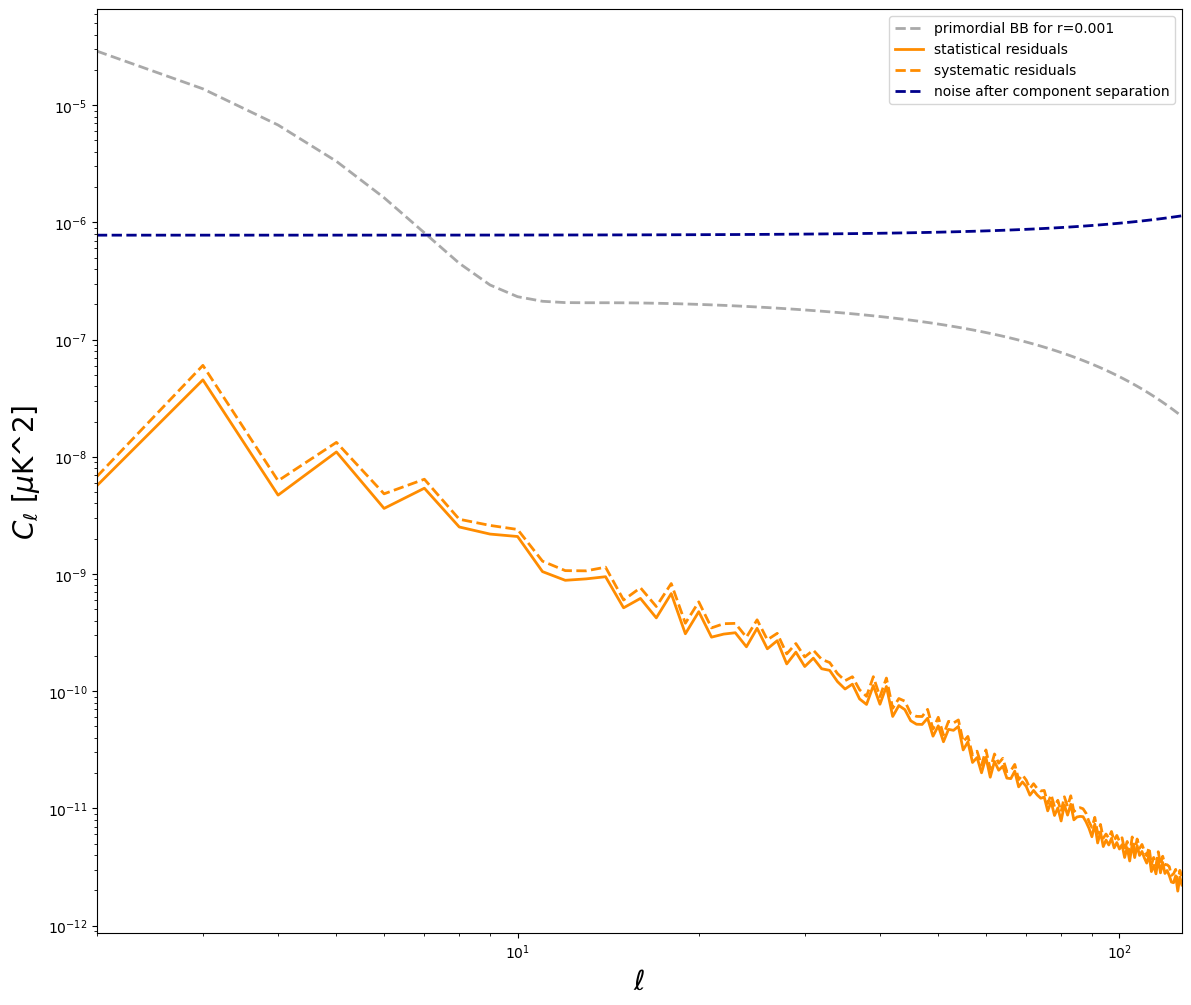

In [201]:
lmin= 2
lmax= 127
ell = np.arange(lmin, lmax+1)


Cl_fid = {}
Cl_fid['BB'] = _get_Cl_cmb(Alens=0.1, r=0.001)[2][lmin:lmax+1]
Cl_fid['BuBu'] = _get_Cl_cmb(Alens=0.0, r=1.0)[2][lmin:lmax+1]
Cl_fid['BlBl'] = _get_Cl_cmb(Alens=1.0, r=0.0)[2][lmin:lmax+1]



fig = pl.figure( figsize=(14,12), facecolor='w', edgecolor='k' )
ax = pl.gca()
left, bottom, width, height = [0.2, 0.2, 0.15, 0.2]

# ax.loglog(ell, Cl_BB_r_001, color='DarkGray', linestyle='-', label='BB tot', linewidth=2.0)
ax.loglog(ell, Cl_BB_r_001 , color='DarkGray', linestyle='--', label='primordial BB for r='+str(0.001), linewidth=2.0)
ax.loglog(ell, stat, 'DarkOrange', label='statistical residuals', linewidth=2.0)
ax.loglog(ell, bias, 'DarkOrange', linestyle='--', label='systematic residuals', linewidth=2.0)
ax.loglog(ell, noise, 'DarkBlue', linestyle='--', label='noise after component separation', linewidth=2.0)
# ax.loglog(ell, Cl_BB_residual, 'DarkGreen', linestyle='--', label='residual', linewidth=1.0)
ax.legend()
ax.set_xlabel('$\ell$', fontsize=20)
ax.set_ylabel('$C_\ell$ [$\mu$K^2]', fontsize=20)
ax.set_xlim(lmin,lmax)

[1.73245921e-13 1.64300311e-12 1.62428441e-13 3.33631704e-13
 1.28427616e-13 1.59372453e-13 7.07573878e-14 6.30002786e-14
 5.57343259e-14 3.03050533e-14 2.71886579e-14 2.30987843e-14
 2.86939958e-14 1.39320675e-14 1.89558653e-14 1.32592754e-14
 2.00135187e-14 9.34565155e-15 1.34714639e-14 8.33499005e-15
 9.32868908e-15 8.69525476e-15 6.77169571e-15 9.68862567e-15
 6.26791814e-15 7.27684653e-15 4.39475385e-15 6.26810296e-15
 4.49868799e-15 5.43245135e-15 4.27888254e-15 4.36828104e-15
 3.59721180e-15 3.05992315e-15 3.17996187e-15 2.93094132e-15
 2.47399321e-15 3.51829119e-15 2.41485892e-15 3.40716688e-15
 1.72728424e-15 2.34960692e-15 2.17278005e-15 1.70321881e-15
 1.49082821e-15 1.58301098e-15 1.64701288e-15 1.15973866e-15
 1.49430961e-15 1.18133471e-15 1.23332012e-15 1.46333950e-15
 1.24553491e-15 9.11666718e-16 9.10014734e-16 7.50448374e-16
 8.05907604e-16 6.60196593e-16 7.66023297e-16 5.75411008e-16
 7.88505571e-16 6.35930452e-16 7.08582845e-16 5.71681822e-16
 5.60805218e-16 6.659555

(2, 127)

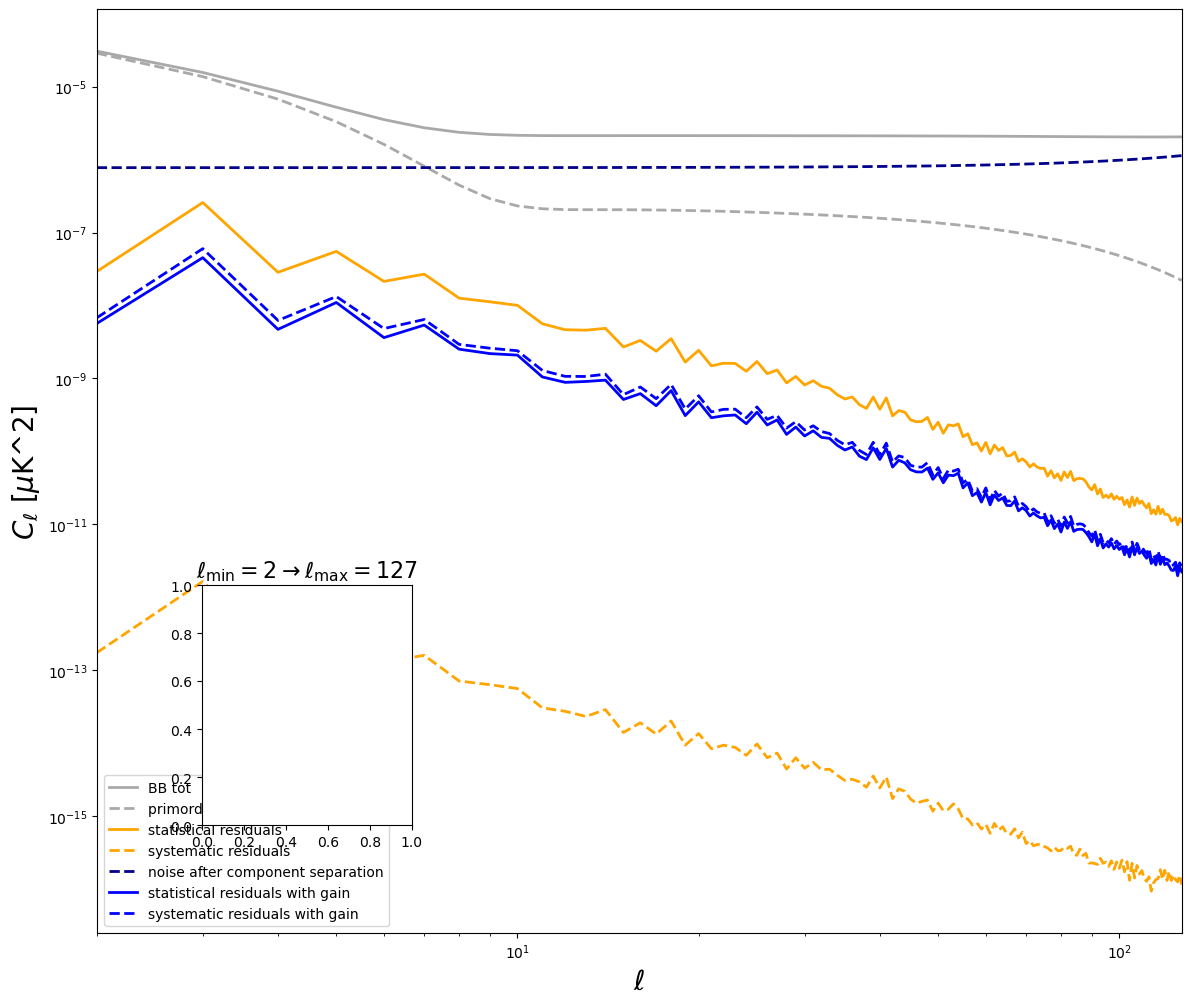

In [202]:
# #FORECAST WITHOUT GAIN
d_fgs=freq_maps
instrument = standardize_instrument(instrument)
nside = hp.npix2nside(d_fgs.shape[-1])
n_stokes = d_fgs.shape[1]
n_freqs = d_fgs.shape[0]
invN = np.diag(hp.nside2resol(nside, arcmin=True) / (instrument.depth_p))**2
mask = d_fgs[0, 0, :] != 0.
fsky = mask.astype(float).sum() / mask.size
ell = np.arange(lmin, lmax+1)
    

# ############################################################################
# # 1. Component separation using the noise-free foregrounds templare
# grab the max-L spectra parameters with the associated error bars
   
A = MixingMatrix(*components)
A_ev = A.evaluator(instrument.frequency)
A_dB_ev = A.diff_evaluator(instrument.frequency)

x0 = np.array([x for c in components for x in c.defaults])
if n_stokes == 3:  # if T and P were provided, extract P
    d_comp_sep = d_fgs[:, 1:, :]
else:
    d_comp_sep = d_fgs

res = comp_sep(A_ev, d_comp_sep.T, invN, A_dB_ev, A.comp_of_dB, x0)

res.params = A.params
res.s = res.s.T
A_maxL = A_ev(res.x) 
A_dB_maxL = A_dB_ev(res.x)
A_dBdB_maxL = A.diff_diff_evaluator(instrument.frequency)(res.x)


# ############################################################################
# # 2. Estimate noise after component separation
### A^T N_ell^-1 A
   
i_cmb = A.components.index('CMB')
Cl_noise = _get_Cl_noise(instrument, A_maxL, lmax)[i_cmb, i_cmb, lmin:]


# ############################################################################
# # 3. Compute spectra of the input foregrounds maps
# ### TO DO: which size for Cl_fgs??? N_spec != 1 ? 

if n_stokes == 3:  
    d_spectra = d_fgs
else:  # Only P is provided, add T for map2alm
    d_spectra = np.zeros((n_freqs, 3, d_fgs.shape[2]), dtype=d_fgs.dtype)
    d_spectra[:, 1:] = d_fgs

# Compute cross-spectra
almBs = [hp.map2alm(freq_map, lmax=lmax, iter=10)[2] for freq_map in d_spectra]
Cl_fgs = np.zeros((n_freqs, n_freqs, lmax+1), dtype=d_fgs.dtype)
for f1 in range(n_freqs):
    for f2 in range(n_freqs):
        if f1 > f2:
            Cl_fgs[f1, f2] = Cl_fgs[f2, f1]
        else:
            Cl_fgs[f1, f2] = hp.alm2cl(almBs[f1], almBs[f2], lmax=lmax)

Cl_fgs = Cl_fgs[..., lmin:] / fsky

# ############################################################################
# # 4. Estimate the statistical and systematic foregrounds residuals
  
W_maxL = W(A_maxL, invN=invN)[i_cmb, :]
W_dB_maxL = W_dB(A_maxL, A_dB_maxL, A.comp_of_dB, invN=invN)[:, i_cmb]
W_dBdB_maxL = W_dBdB(A_maxL, A_dB_maxL, A_dBdB_maxL,A.comp_of_dB, invN=invN)[:, :, i_cmb]

   
V_maxL = np.einsum('ij,ij...->...', res.Sigma, W_dBdB_maxL)
    

# Check dimentions
assert ((n_freqs,) == W_maxL.shape == W_dB_maxL.shape[1:]
                    == W_dBdB_maxL.shape[2:] == V_maxL.shape)
assert (len(res.params) == W_dB_maxL.shape[0] 
                        == W_dBdB_maxL.shape[0] == W_dBdB_maxL.shape[1])

# elementary quantities defined in Stompor, Errard, Poletti (2016)
Cl_xF = {}
Cl_xF['yy'] = _utmv(W_maxL, Cl_fgs.T, W_maxL)  # (ell,)
Cl_xF['YY'] = _mmm(W_dB_maxL, Cl_fgs.T, W_dB_maxL.T)  # (ell, param, param)
Cl_xF['yz'] = _utmv(W_maxL, Cl_fgs.T, V_maxL )  # (ell,)
Cl_xF['Yy'] = _mmv(W_dB_maxL, Cl_fgs.T, W_maxL)  # (ell, param)
Cl_xF['Yz'] = _mmv(W_dB_maxL, Cl_fgs.T, V_maxL)  # (ell, param)


# # bias and statistical foregrounds residuals
res.noise = Cl_noise
res.bias = Cl_xF['yy'] + 2 * Cl_xF['yz']  # S16, Eq 23
res.stat = np.einsum('ij, lij -> l', res.Sigma, Cl_xF['YY'])  # E11, Eq. 12
res.var = res.stat**2 + 2 * np.einsum('li, ij, lj -> l', # S16, Eq. 28
                                        Cl_xF['Yy'], res.Sigma, Cl_xF['Yy'])

print(res.bias)

Alens=1.0 
r=0.001   

Cl_fid = {}
Cl_fid['BB'] = _get_Cl_cmb(Alens=Alens, r=r)[2][lmin:lmax+1]
Cl_fid['BuBu'] = _get_Cl_cmb(Alens=0.0, r=1.0)[2][lmin:lmax+1]
Cl_fid['BlBl'] = _get_Cl_cmb(Alens=1.0, r=0.0)[2][lmin:lmax+1]

res.BB = Cl_fid['BB']*1.0
res.BuBu = Cl_fid['BuBu']*1.0
res.BlBl = Cl_fid['BlBl']*1.0
res.ell = ell

fig = pl.figure( figsize=(14,12), facecolor='w', edgecolor='k' )
ax = pl.gca()
left, bottom, width, height = [0.2, 0.2, 0.15, 0.2]
ax0 = fig.add_axes([left, bottom, width, height])
ax0.set_title(r'$\ell_{\min}=$'+str(lmin)+ r'$ \rightarrow \ell_{\max}=$'+str(lmax), fontsize=16)


ax.loglog(ell, Cl_fid['BB'], color='DarkGrey', linestyle='-', label='BB tot', linewidth=2.0)
ax.loglog(ell, Cl_fid['BuBu']*r , color='DarkGrey', linestyle='--', label='primordial BB for r='+str(r), linewidth=2.0)
ax.loglog(ell, res.stat, 'Orange', label='statistical residuals', linewidth=2.0)
ax.loglog(ell, res.bias, 'Orange', linestyle='--', label='systematic residuals', linewidth=2.0)
ax.loglog(ell, res.noise, 'DarkBlue', linestyle='--', label='noise after component separation', linewidth=2.0)

#compare with gain
ax.loglog(ell, stat, 'Blue', label='statistical residuals with gain', linewidth=2.0)
ax.loglog(ell, bias, 'Blue', linestyle='--', label='systematic residuals with gain', linewidth=2.0)

ax.legend()
ax.set_xlabel('$\ell$', fontsize=20)
ax.set_ylabel('$C_\ell$ [$\mu$K^2]', fontsize=20)
ax.set_xlim(lmin,lmax)


In [203]:
# ## 5.1. data 
# Cl_obs = Cl_fid['BB'] + Cl_noise
# dof = (2 * ell + 1) * fsky
# YY = Cl_xF['YY']
# tr_SigmaYY = np.einsum('ij, lji -> l', sigma_params_square, YY)

# ## 5.2. modeling
# def cosmo_likelihood(r_):
#     # S16, Appendix C
#     Cl_model = Cl_fid['BlBl'] * Alens + Cl_fid['BuBu'] * r_ + Cl_noise
#     dof_over_Cl = dof / Cl_model
#     ## Eq. C3
#     U = np.linalg.inv(sigma_params_square_inv + np.dot(YY.T, dof_over_Cl))
        
#     ## Eq. C9
#     first_row = np.sum(dof_over_Cl * (
#         Cl_obs * (1 - np.einsum('ij, lji -> l', U, YY) / Cl_model) 
#         + tr_SigmaYY))
#     second_row = - np.einsum(
#         'l, m, ij, mjk, kf, lfi',
#         dof_over_Cl, dof_over_Cl, U, YY, sigma_params_square, YY)
#     trCinvC = first_row + second_row
       
#     ## Eq. C10
#     first_row = np.sum(dof_over_Cl * (Cl_xF['yy'] + 2 * Cl_xF['yz']))
#     ### Cyclicity + traspose of scalar + grouping terms -> trace becomes
#     ### Yy_ell^T U (Yy + 2 Yz)_ell'
#     trace = np.einsum('li, ij, mj -> lm',
#                         Cl_xF['Yy'], U, Cl_xF['Yy'] + 2 * Cl_xF['Yz'])
#     second_row = - _utmv(dof_over_Cl, trace, dof_over_Cl)
#     trECinvC = first_row + second_row

#     ## Eq. C12
#     logdetC = np.sum(dof * np.log(Cl_model)) - np.log(np.linalg.det(U))

#     # Cl_hat = Cl_obs + tr_SigmaYY

#     ## Bringing things together
#     return trCinvC + trECinvC + logdetC

In [204]:
#  # Likelihood maximization
# r_grid = np.logspace(-5,0,num=500)
# logL = np.array([cosmo_likelihood(r_loc) for r_loc in r_grid])
# ind_r_min = np.argmin(logL)
# r0 = r_grid[ind_r_min]
# if ind_r_min == 0:
#     bound_0 = 0.0
#     bound_1 = r_grid[1]
#     # pl.figure()
#     # pl.semilogx(r_grid, logL, 'r-')
#     # pl.show()
# elif ind_r_min == len(r_grid)-1:
#     bound_0 = r_grid[-2]
#     bound_1 = 1.0
#     # pl.figure()
#     # pl.semilogx(r_grid, logL, 'r-')
#     # pl.show()
# else:
#     bound_0 = r_grid[ind_r_min-1]
#     bound_1 = r_grid[ind_r_min+1]
# print('bounds on r = ', bound_0, ' / ', bound_1)
# print('starting point = ', r0)
# res_Lr = sp.optimize.minimize(cosmo_likelihood, [r0], bounds=[(bound_0,bound_1)])
# print ('    ===>> fitted r = ', res_Lr['x'])

# print ('======= ESTIMATION OF SIGMA(R) =======')
# def sigma_r_computation_from_logL(r_loc):
#     THRESHOLD = 1.00
#     # THRESHOLD = 2.30 when two fitted parameters
#     delta = np.abs( cosmo_likelihood(r_loc) - res_Lr['fun'] - THRESHOLD )
#     # print r_loc, cosmo_likelihood(r_loc),  res_Lr['fun']
#     return delta

# if res_Lr['x'] != 0.0:
#     sr_grid = np.logspace(np.log10(res_Lr['x']), 0, num=25)
# else:
#     sr_grid = np.logspace(-5,0,num=25)
# slogL = np.array([sigma_r_computation_from_logL(sr_loc) for sr_loc in sr_grid ])
# ind_sr_min = np.argmin(slogL)
# sr0 = sr_grid[ind_sr_min]
# print('ind_sr_min = ', ind_sr_min)
# print('sr_grid[ind_sr_min-1] = ', sr_grid[ind_sr_min-1])
# print('sr_grid[ind_sr_min+1] = ', sr_grid[ind_sr_min+1])
# print('sr_grid = ', sr_grid)
# if ind_sr_min == 0:
#     print('case # 1')
#     bound_0 = res_Lr['x']
#     bound_1 = sr_grid[1]
# elif ind_sr_min == len(sr_grid)-1:
#     print('case # 2')
#     bound_0 = sr_grid[-2]
#     bound_1 = 1.0
# else:
#     print('case # 3')
#     bound_0 = sr_grid[ind_sr_min-1]
#     bound_1 = sr_grid[ind_sr_min+1]
# print('bounds on sigma(r) = ', bound_0, ' / ', bound_1)
# print('starting point = ', sr0)
# res_sr = sp.optimize.minimize(sigma_r_computation_from_logL, sr0,
#         bounds=[(bound_0.item(),bound_1.item())],
#         # item required for test to pass but reason unclear. sr_grid has
#         # extra dimension?
#         )
# print ('    ===>> sigma(r) = ', res_sr['x'] -  res_Lr['x'])
# # res.cosmo_params = {}
# # res.cosmo_params['r'] = (res_Lr['x'], res_sr['x']- res_Lr['x'])

# ###############################################################################
# # 6. Produce figures
# print ('======= GRIDDING COSMO LIKELIHOOD =======')
# r_grid = np.logspace(-4,-1,num=500)
# logL = np.array([ cosmo_likelihood(r_loc) for r_loc in r_grid ])
# chi2 = logL - np.min(logL)
# ax0.semilogx( r_grid,  np.exp(-chi2), color='DarkOrange', linestyle='-', linewidth=2.0, alpha=0.8 )
# ax0.axvline(x=r, color='k', linestyle='--')
# ax0.set_ylabel(r'$\mathcal{L}(r)$', fontsize=20)
# ax0.set_xlabel(r'tensor-to-scalar ratio $r$', fontsize=20)
# pl.show()
